## Processing Ocean Color Imagery - Visualize Convert Images to Ocean Color

Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto

def load_img_fn_and_meta(img_dir, count, start):
    i = 0
    j = 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.tif"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            img_metadata.append(gpsphoto.getGPSData(file))
            j += 1
        i += 1
        
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

### Primary Processing Function

In [5]:
def retrieve_imgs_and_metadata(img_dir, count=None, start=0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    imgs = load_images(img_fns)
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    print('Output shape is: ', imgs.shape)
    return(imgs, img_metadata)

### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [ ]:
('data/040321_duml_testing/sky/../skystacks',
 'data/040321_duml_testing/sea/../seastacks')

In [7]:
sky_output = 'data/040321_duml_testing/skystacks'
sea_output = 'data/040321_duml_testing/seastacks'

sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(sea_output, count=10, start=0)

Output shape is:  (7, 6, 1473, 2025)


In [8]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_output, count=20)

Output shape is:  (2, 6, 1472, 2024)


In [9]:
sea_imgs.nbytes / 1e9

1.0022292

Inspect the band means

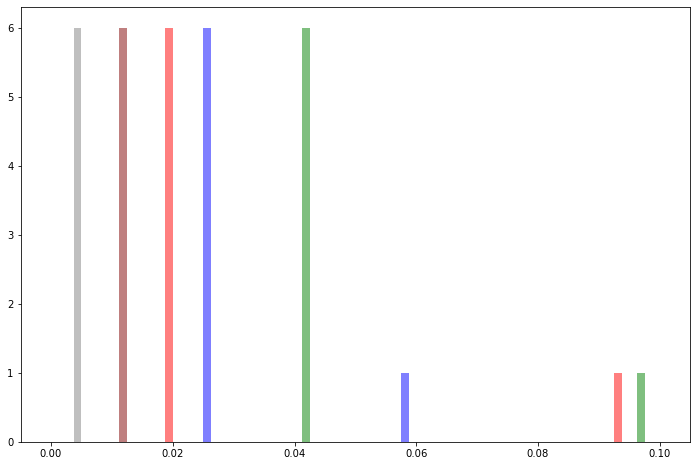

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(np.mean(sea_imgs[:,i],axis=(1,2)).flatten(), range=(0,0.1), bins=80, color=colors[i], alpha=0.5)
    #ax.set_xlim(0,0.10)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

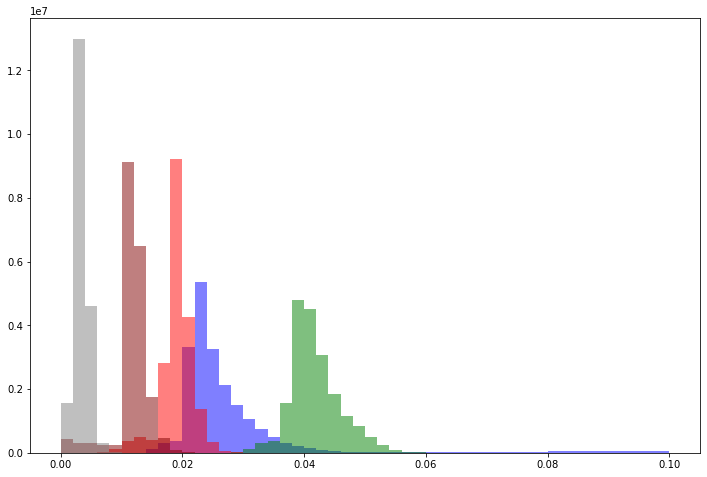

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['blue', 'green', 'red', 'nir', 'red edge']
colors = ['blue', 'green', 'red', 'maroon', 'grey']

for i in range(0,5):
    
    ax.hist(sea_imgs[:40,i].flatten(), range=(0,0.1), bins=50, color=colors[i], alpha=0.5)
    #ax.set_xlim(0,0.10)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

(array([1.78000e+02, 4.84000e+02, 9.16000e+02, 1.05000e+03, 1.35400e+03,
        2.56900e+03, 2.64800e+03, 4.12100e+03, 8.47800e+03, 8.73100e+03,
        9.96600e+03, 1.38400e+04, 1.53970e+04, 2.54660e+04, 2.18960e+04,
        2.25640e+04, 2.92800e+04, 2.76170e+04, 2.90880e+04, 3.95940e+04,
        3.66510e+04, 4.44470e+04, 6.22420e+04, 5.57120e+04, 7.45150e+04,
        5.81370e+04, 6.17570e+04, 8.94030e+04, 9.04160e+04, 1.07106e+05,
        1.55360e+05, 1.46467e+05, 1.63233e+05, 2.26225e+05, 1.85279e+05,
        1.85570e+05, 2.06287e+05, 1.43004e+05, 1.54039e+05, 1.09279e+05,
        9.62970e+04, 9.98560e+04, 5.76810e+04, 3.96010e+04, 3.04740e+04,
        1.70770e+04, 1.14000e+04, 6.22200e+03, 3.06500e+03, 7.86000e+02]),
 array([6.25  , 6.2936, 6.3372, 6.3808, 6.4244, 6.468 , 6.5116, 6.5552,
        6.5988, 6.6424, 6.686 , 6.7296, 6.7732, 6.8168, 6.8604, 6.904 ,
        6.9476, 6.9912, 7.0348, 7.0784, 7.122 , 7.1656, 7.2092, 7.2528,
        7.2964, 7.34  , 7.3836, 7.4272, 7.4708, 7.51

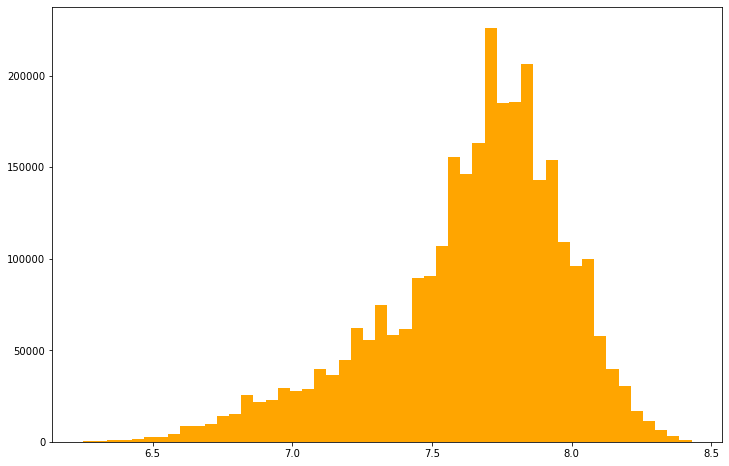

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

band_names = ['thermal']
colors = ['orange']

ax.hist(sea_imgs[2,5].flatten()* 32768 / 100 - 273, bins=50, color=colors[0])

### Cut off the bright outliers

Visualize a few random images and take out the X% of brightest pixels

In [13]:
full_sea_img = sea_imgs[0]

full_sea_img.shape

(6, 1473, 2025)

In [14]:
# TODO this should probably pick out the darkest from each band and then use those all together

In [15]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.75, band=4, return_imgs=False, visualize=False, sky=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        print(i)
        if np.mean(imgs[i,0]) > 5 and not sky: # why am I doing this? I assume for thermal
            print(np.mean(imgs[i,0]))
            print('hitting this filter for brightness')
            continue
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        blue_spec = None
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
            if img_idx == 0:
                blue_spec = np.mean(sorted_band[idx])
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        #if blue_spec <0.02:
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)

In [16]:
def remove_bright_pix(im, lowest_percent=0.75, band=0):

    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=band, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    # cut out the super dark pix
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1 ] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [17]:
# TODO update this with the proper coefficients

In [18]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [19]:
def chla_img(sky_spectra, dark_pix, wind_speed = 5):
    dp_shape = dark_pix.shape
    sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (5,1))
    water_leaving = dark_pix.reshape(5,-1) - sky_rad_correction
    
    chlas = []
    for i in range(water_leaving.shape[-1]):
        chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))
    chlas = np.array(chlas)
    return(chlas.reshape(dp_shape[1:3]))

In [20]:
def visualize_chla_across_thresholds(im, sky_spectra):
    thresholds = np.arange(0.1,1,0.1)
    fig, ax = plt.subplots(len(thresholds),1, figsize=(12,40))
    for i,lowest_percent in enumerate(thresholds):
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        full_chla_img = chla_img(sky_spectra, dark_pix.reshape(im.shape), wind_speed = 5)
        
        ims = ax[i].imshow(full_chla_img, interpolation='nearest', cmap='jet', vmax=0.5)
        ax[i].set_title(lowest_percent)
        #current_cmap = matplotlib.cm.get_cmap()
        #current_cmap.set_bad(color='yellow')
        fig.colorbar(ims, ax=ax[i], fraction=0.046, pad=0.04)

In [21]:
def visualize_darkest_pixels(im, lowest_percent=0.5, band=0, only_img=False):
    if im.shape[0] == 6: # because these are altum images
        im_flat = im[:-1].reshape(5,-1)
    else:
        im_flat = im.reshape(5,-1)
    # sort to get the darkest x pixels
    
    # visualize all bands and an RGB composite
    

    band_names = ['blue', 'green', 'red', 'nir', 'red edge']
    colors = ['blue', 'green', 'red', 'maroon', 'grey']
    
    fig, ax = plt.subplots(1,5, figsize=(16,14))
    for i,a in enumerate(ax):
        ims = a.imshow(im[i], cmap='jet', interpolation='none', vmax=0.05, vmin=0)
        a.set_title(band_names[i])
        fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
        a.set_xticks([])
        a.set_yticks([])
#     ims = ax[5].imshow(im[0]/im[1], cmap='jet', vmax=10, vmin=0)
#     ax[5].set_title('blue/green')
#     ax[5].set_xticks([])
#     ax[5].set_yticks([])
#     fig.colorbar(ims, ax=ax[5], fraction=0.046, pad=0.04)
    #plt.savefig('openoceanfull.png')
    fig.show()
        
    if not only_img:
        
        # visualize all bands with the darkest pixels removed
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=band)


        fig, ax = plt.subplots(1,5, figsize=(16,14))
        for i,a in enumerate(ax):
            ims = a.imshow(dark_pix[i].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=0.05, vmin=0)
            a.set_title(band_names[i])
            fig.colorbar(ims, ax=a, fraction=0.046, pad=0.04)
            a.set_xticks([])
            a.set_yticks([])
        #plt.savefig('openoceanfilter.png')
        fig.show()


        fig, ax = plt.subplots(figsize=(12,8))
        colors = ['blue', 'green', 'red', 'grey', 'black']
        for i in range(0,5):
            ax.hist(dark_pix[i].flatten(), density=True, bins=50, color=colors[i], alpha=0.5)

        for i in range(0,5):
            print(np.count_nonzero(~np.isnan(dark_pix[i])))
        ax.set_xlim(0,0.1)

        return(dark_pix.reshape(5,im.shape[1], im.shape[2]))
    else:
        return(None)

In [22]:
sea_imgs[1].shape

(6, 1473, 2025)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0


/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


2237118
2237118
2237118
2237118
2237118


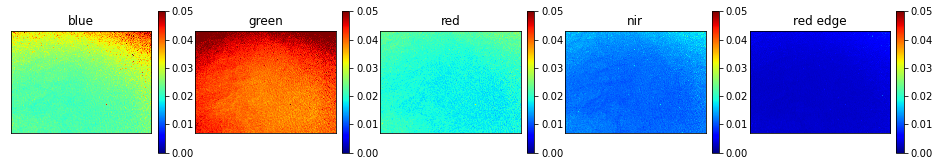

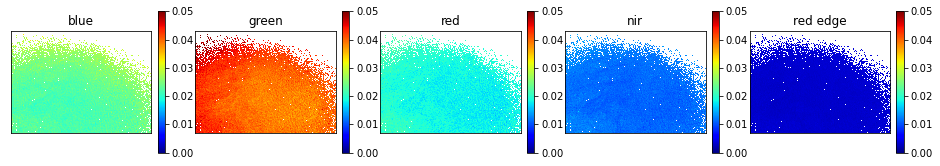

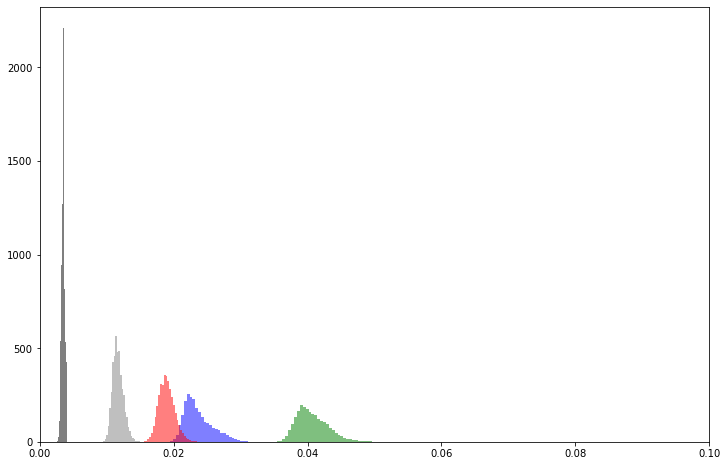

In [23]:
lowest_percent = 0.75
dark_pix_dark = visualize_darkest_pixels(sea_imgs[-1], lowest_percent=lowest_percent, band=4)

In [24]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.02370391, 0.04073335, 0.018953  , 0.0116955 , 0.00350819])

In [25]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.02370391, 0.04073335, 0.018953  , 0.0116955 , 0.00350819])

In [26]:
np.mean(sea_imgs[4],axis=(1,2))

array([0.0259348 , 0.04240272, 0.01965247, 0.01232835, 0.00384736,
       0.85622588])

In [27]:
np.mean(sea_imgs[3],axis=(1,2))

array([0.05844315, 0.09648808, 0.09315098, 0.16077691, 0.21568781,
       0.87979602])

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


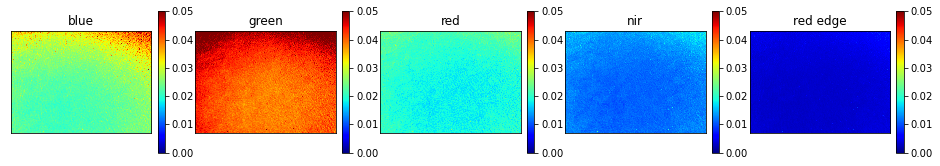

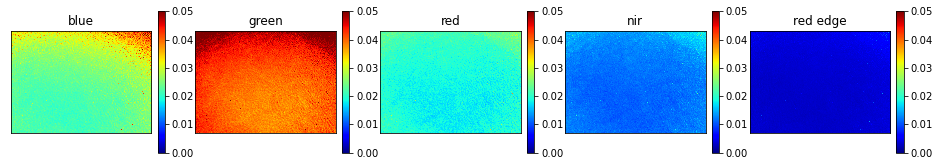

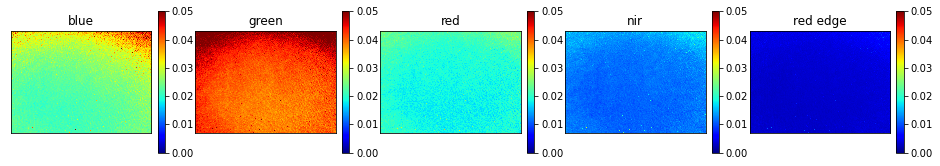

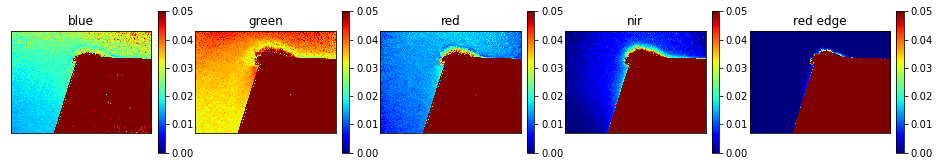

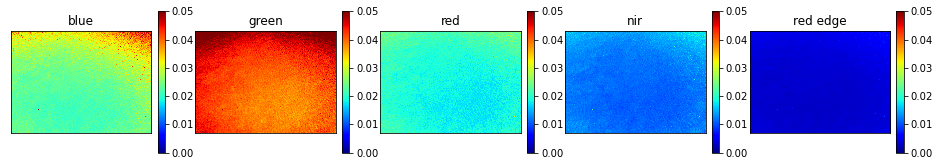

In [28]:
for i in range(0,5):
    visualize_darkest_pixels(sea_imgs[i], only_img=True)

Calculate spectra based on that brightness threshold

0
0 0.003509521484375
1
1 0.003448486328125
2
2 0.00347900390625
3
3 0.003509521484375
4
4 0.00347900390625


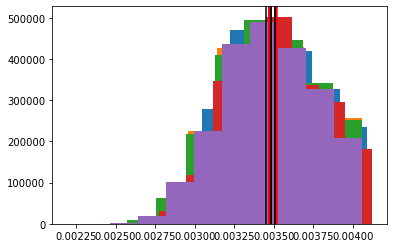

In [70]:
lowest_percent = .75

sea_spectra, sea_idxs = calculate_spectra_from_darkest_px(sea_imgs, lowest_percent=lowest_percent, band=4, visualize=True)

In [71]:
#remove outliers as necessary
#del sea_spectra[162]
#del sea_img_metadata[162]

0
0 0.020294189453125
1
1 0.019866943359375


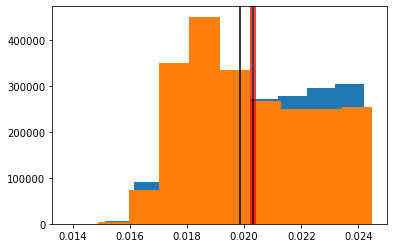

In [72]:
lowest_percent = .75

sky_spectra = calculate_spectra_from_darkest_px(sky_imgs, lowest_percent=lowest_percent, band=4, visualize=True, sky=True)

In [73]:
sea_imgs[0,:-1].shape

(5, 1472, 2024)

In [74]:
#visualize_chla_across_thresholds(sea_imgs[0,:-1], sky_spectra)

In [80]:
sky_spectra[0][0]

[0.11957297635432158,
 0.0726555571179418,
 0.03560130545764798,
 0.03241756081601602,
 0.02039039425200638]

Inspect variability of spectra

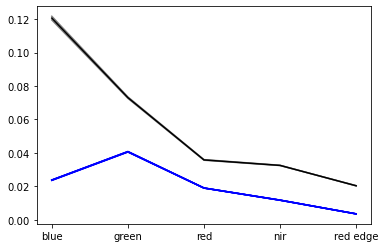

In [83]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']
for spectra in sea_spectra:
    plt.plot(band_names, spectra, color='blue')
    
for spectra in sky_spectra[0]:
    plt.plot(band_names, spectra, color='grey')
plt.plot(np.median(sky_spectra[0], axis=0), color='black')

### Correct for sun glint

TODO currently just averaging sky spectra for removal but could easily interpolate across and incorporate time into which is chosen

In [84]:
def sun_glint_removal(sea_spectra, sky_spectra, wind_speed, method='ruddick2006'):
    sky_spectra = np.median(sky_spectra,axis=0)
    water_leaving_spectra = []
    # TODO will add in Zhang and other approaches
    if method == 'ruddick2006':
        for water_spec in sea_spectra:
            water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed)
            water_leaving_spectra.append(water_leaving)
    return(water_leaving_spectra)

In [85]:
# TODO will pull this from the ship CSV in practice
wind_speed = 3
water_leaving_spec = sun_glint_removal(sea_spectra, sky_spectra[0], wind_speed=wind_speed)

#### Inspect the output from the removal

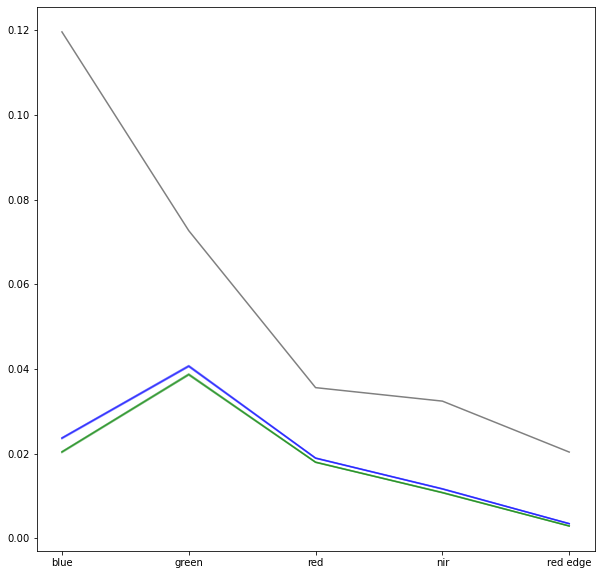

In [87]:
fig, ax = plt.subplots(figsize=(10,10))

for spectra in sea_spectra:
    ax.plot(band_names, spectra, color='blue', alpha=0.3)
    
for spectra in water_leaving_spec:
    ax.plot(band_names, spectra, color='green', alpha=0.3)
    
ax.plot(band_names, np.array(sky_spectra[0][0]), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

### Chlorophyll retrieval algorithm

TODO will need to modify the coefficients of this algorithm if possible
TODO will need to interpolate the spectra from the senop into the right band widths for this algorithm at this step

Run chla retrieval on water leaving spectra

In [88]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [89]:
chla_list

[13.616772592420581,
 13.697805149312542,
 13.542767329046928,
 13.692718207692481,
 13.912566654749305]

### Save spectra and chla values as a geopandas dataframe along with image metadata

In [90]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [91]:
from datetime import datetime
import pandas as pd

def convert_to_ocean_color_gdf(chla_list, spectra_list, img_metadata):
    chla_dates = []
    for im in img_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']

        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        chla_dates.append(date_time_obj)
    lons = []
    lats = []
    for im in img_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        
        
    chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'spectra' : spectra_list,
     'time' : chla_dates})

    chla_gdf = gpd.GeoDataFrame(
        chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
    
    return(chla_gdf)

In [92]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])

gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,13.616773,34.714919,-76.674661,"[0.02049147847904074, 0.03880334928096327, 0.0...",2021-03-04 16:20:32,POINT (-76.67466 34.71492)
1,13.697805,34.715006,-76.674322,"[0.0203378846332767, 0.038575373113309885, 0.0...",2021-03-04 16:20:28,POINT (-76.67432 34.71501)
2,13.542767,34.714953,-76.674492,"[0.02046859820312628, 0.03870196592183027, 0.0...",2021-03-04 16:20:30,POINT (-76.67449 34.71495)
3,13.692718,34.714897,-76.674803,"[0.020488812334633382, 0.03885767402700638, 0....",2021-03-04 16:20:34,POINT (-76.67480 34.71490)
4,13.912567,34.715056,-76.674189,"[0.02024841828340284, 0.03857015173686733, 0.0...",2021-03-04 16:20:26,POINT (-76.67419 34.71506)


<AxesSubplot:>

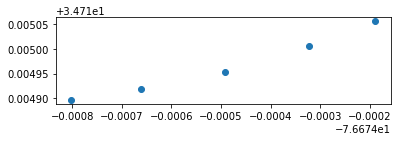

In [93]:
gdf.plot()

<AxesSubplot:>

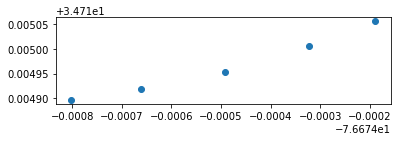

In [94]:
gdf = gdf.drop(gdf[gdf.Latitude == 0].index)
gdf.plot()

Save out the file

In [95]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')

### Inspect Full Images

In [96]:
sky_spectra[0][0]

[0.11957297635432158,
 0.0726555571179418,
 0.03560130545764798,
 0.03241756081601602,
 0.02039039425200638]

In [97]:
full_img_chla = chla_img(sky_spectra[0][0], dark_pix_dark)
np.nanmax(full_img_chla), np.nanmedian(full_img_chla), np.nanmean(full_img_chla)

(143.16444776130828, 14.404135176069314, 15.034206122251092)

In [98]:
dark_pix_dark.shape

(5, 1472, 2024)

In [99]:
full_img_chla.shape

(1472, 2024)

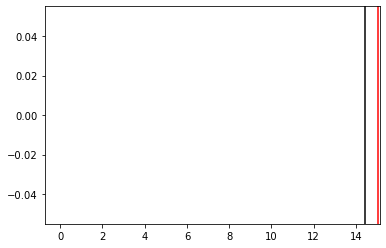

In [100]:
plt.hist(full_img_chla.flatten(), range=(0,1), bins=60)
plt.axvline(np.nanmedian(full_img_chla), c='black')
plt.axvline(np.nanmean(full_img_chla), c='red')
plt.show()

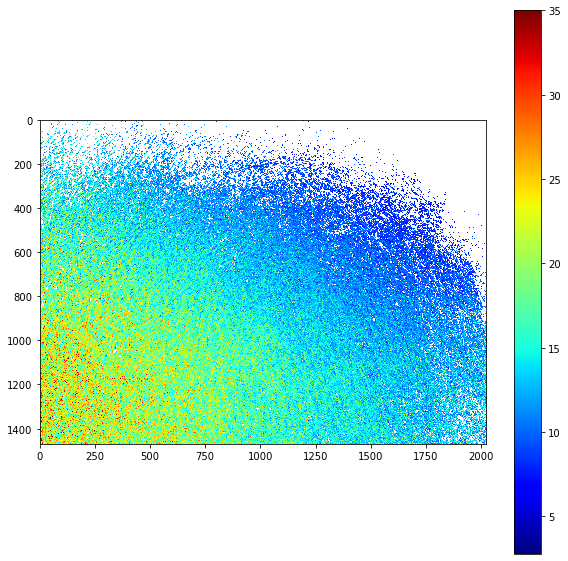

In [106]:
import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(full_img_chla, interpolation='none', cmap='jet', vmax=35)
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='yellow')

fig.colorbar(im)

In [102]:
sea_img_metadata[-1]

{'Latitude': 34.71505555555556,
 'Longitude': -76.67418888888889,
 'Altitude': 46.8,
 'UTC-Time': '16:20:26',
 'Date': '03/04/2021'}

In [103]:
### need to read in all the exifdata from the image to get heading and everything else

### then determine the correct transformation based on all that data

### then write the transformed image into a geotiff

In [107]:
! ls data

040321_duml_testing  260920_shearwateroffshore_dual


In [330]:
import exifread
# Open image file for reading (binary mode)
path_name = 'data/040321_duml_testing/0005SET/000/IMG_0097_4.tif'
#path_name = 'data/040321_duml_testing/0005SET/003/IMG_0713_3.tif'
#path_name = 'data/040321_duml_testing/0005SET/003/IMG_0685_2.tif'



f = open(path_name, 'rb')

# Return Exif tags
tags = exifread.process_file(f)
tags

{'Image SubfileType': (0x00FE) Long=Full-resolution Image @ 6381806,
 'Image ImageWidth': (0x0100) Long=2064 @ 6381818,
 'Image ImageLength': (0x0101) Long=1544 @ 6381830,
 'Image BitsPerSample': (0x0102) Short=16 @ 6381842,
 'Image Compression': (0x0103) Short=Uncompressed @ 6381854,
 'Image PhotometricInterpretation': (0x0106) Short=1 @ 6381866,
 'Image Make': (0x010F) ASCII=MicaSense @ 6374086,
 'Image Model': (0x0110) ASCII=Altum @ 6374096,
 'Image StripOffsets': (0x0111) Long=[8, 412808, 825608, 1238408, 1651208, 2064008, 2476808, 2889608, 3302408, 3715208, 4128008, 4540808, 4953608, 5366408, 5779208, 6192008] @ 6374102,
 'Image Orientation': (0x0112) Short=Horizontal (normal) @ 6381914,
 'Image SamplesPerPixel': (0x0115) Short=1 @ 6381926,
 'Image RowsPerStrip': (0x0116) Short=100 @ 6381938,
 'Image StripByteCounts': (0x0117) Long=[412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 412800, 181632] @ 6374166,
 'Image Pla

Worth noting that this notebook https://github.com/micasense/imageprocessing/blob/e3744671c521056de46c3d05c3e9446a971662c9/MicaSense%20Image%20Processing%20Tutorial%203.ipynb has this caveat about the sensor:
        
An onboard orientation sensor provides a fairly rough version of the earth-fixed orientation of the DLS. The quality of this orientation varies based on the quality of the sensor installation and calibration, but in even the best cases it has a few degrees of error.

In [331]:
path_name

'data/040321_duml_testing/0005SET/000/IMG_0097_4.tif'

In [332]:
import os
import micasense.image as image
img = image.Image(path_name)

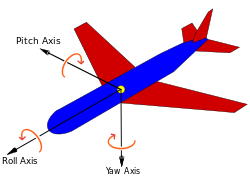

In [333]:
import math
# this fcn returns (yaw,pitch,roll) tuples in radians of the earth-fixed dls pose
yaw, pitch, roll = np.array([img.dls_yaw, img.dls_pitch, img.dls_roll]) * 180/math.pi # convert this to degrees from rads for cameratransform
img.dls_yaw, img.dls_pitch, img.dls_roll, yaw, pitch, roll

(-1.0416555191202088,
 -0.05914077132144412,
 0.1633945449319001,
 -59.682464952096794,
 -3.388516593867085,
 9.36181782005857)

In [334]:
sensor_offset = 40 # this is the difference of the sensor and the DLS

In [335]:
img.focal_length

7.821876914999999

In [336]:
img.focal_plane_resolution_px_per_mm

(289.855072, 289.855072)

In [337]:
img.size()

(2064, 1544)

In [477]:
import cameratransform as ct

# intrinsic camera parameters
f = img.focal_length # returns focal length in mm
# dividing the pixel size by the focal plane resolution in mm to get sensor size - px/(px/mm) leaves mm
sensor_size = img.size()[0] / img.focal_plane_resolution_px_per_mm[0], img.size()[1] / img.focal_plane_resolution_px_per_mm[1]    # in mm
image_size = img.size()    # in px

cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         sensor=sensor_size,
                                         image=image_size),
               ct.SpatialOrientation(elevation_m=img.altitude,
                                     tilt_deg=pitch+sensor_offset+10,
                                     roll_deg=0,
                                    heading_deg=yaw-10))

# gps pts are lat lon
cam.setGPSpos(img.latitude, img.longitude, img.altitude)

In [478]:
img.altitude

46.298

In [479]:
sensor_size

(7.12080001139328, 5.32680000852288)

In [480]:
im.shape

(1544, 2064)

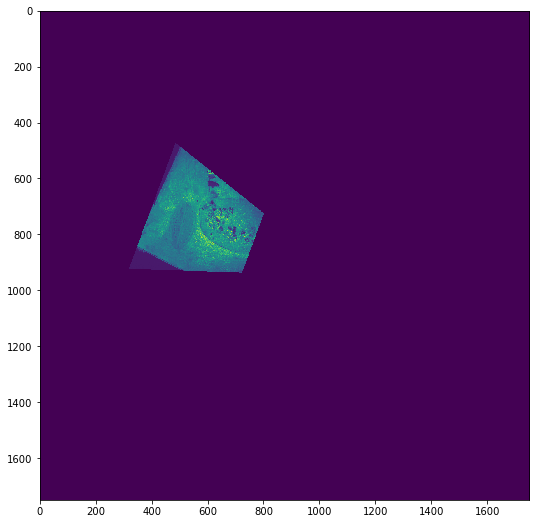

In [481]:
fig,ax = plt.subplots(figsize=(9,9))
scaling = .2
im = plt.imread(path_name)
top_im = cam.getTopViewOfImage(im, [-175, 175,-175, 175], scaling=scaling, do_plot=False)
ax.imshow(top_im, interpolation='none')
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");

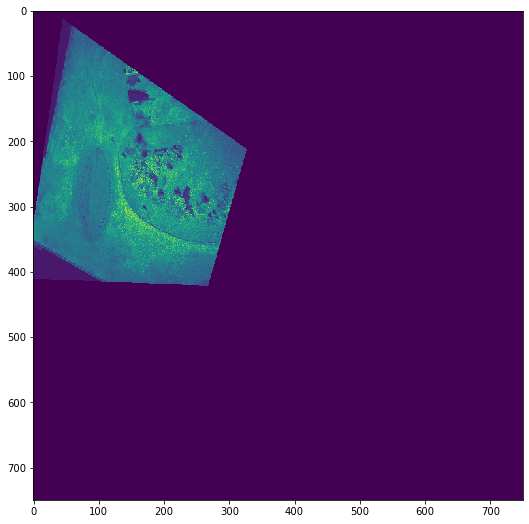

In [390]:
fig,ax = plt.subplots(figsize=(9,9))
scaling = .2
im = plt.imread(path_name)
top_im = cam.getTopViewOfImage(im, [-75, 75,-75, 75], scaling=scaling, do_plot=False)
ax.imshow(top_im, interpolation='none')
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");

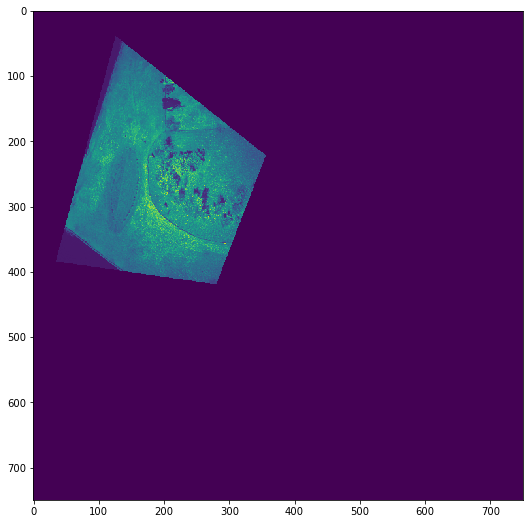

In [357]:
fig,ax = plt.subplots(figsize=(9,9))
scaling = .2
im = plt.imread(path_name)
top_im = cam.getTopViewOfImage(im, [-175, 175,-75, 75], scaling=scaling, do_plot=False)
ax.imshow(top_im, interpolation='none')
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");

In [482]:
from PIL import Image
im = Image.fromarray(top_im)
im.save("my_file.png")

In [483]:
750/2

375.0

In [484]:
top_im.shape

(1750, 1750)

In [485]:
img.latitude, img.longitude

(34.7155427, -76.672801)

we need to take the center GPS point which is where the drone was, plus 100m y -100m x to get image point (0,0) and convert that to GPS

then do the same for all the corners

and then use that to make a GCP based transformation of the image and then map it

In [486]:
import math

def calc_lat_lon(lat, lon, dn, de):
    #Earth’s radius, sphere
    R=6378137

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*math.cos(math.pi*lat/180))

    #OffsetPosition, decimal degrees
    lat1 = lat + dLat * 180/math.pi
    lon1 = lon + dLon * 180/math.pi
    return(lat1,lon1,0)
    

def output_corners(camera_lat, camera_lon, offset):
    #Position, decimal degrees
    lat = img.latitude
    lon = img.longitude

    top_left = calc_lat_lon(lat, lon, offset, -offset) # top left corner
    top_right = calc_lat_lon(lat, lon, offset, offset) # top right corner
    bottom_right = calc_lat_lon(lat, lon, -offset, offset) # bottom right corner
    bottom_left = calc_lat_lon(lat, lon, -offset, -offset) # bottom left corner
    
    return(top_left, top_right, bottom_right, bottom_left)

In [487]:
import math
import geopy
import geopy.distance

def calc_lat_lon(lat, lon, dist, bearing):
    # Define starting point.
    start = geopy.Point(lat, lon)
    
    dist = math.sqrt(dist**2 + dist**2) / 1000

    # Define a general distance object, initialized with a distance in km.
    d = geopy.distance.distance(kilometers = dist) # 750/2*0.2 / 1000

    # Use the `destination` method with a bearing of 0 degrees (which is north)
    # in order to go from point `start` 1 km to north.
    lat1, lon1 = geopy.Point(d.destination(point=start, bearing=bearing)).format_decimal().split(',')
    lat1, lon1 = float(lat1), float(lon1)
    return(lat1,lon1,0)
    

def output_corners(camera_lat, camera_lon, dist):
    #Position, decimal degrees
    lat = img.latitude
    lon = img.longitude

    top_left = calc_lat_lon(lat, lon, dist, 315) # top left corner
    top_right = calc_lat_lon(lat, lon, dist, 45) # top right corner
    bottom_right = calc_lat_lon(lat, lon, dist, 135) # bottom right corner
    bottom_left = calc_lat_lon(lat, lon, dist, 225) # bottom left corner
    
    return(top_left, top_right, bottom_right, bottom_left)

In [488]:
import geopy
import geopy.distance

# Define starting point.
start = geopy.Point(34.7150963, -76.6732313)

# Define a general distance object, initialized with a distance of 1 km.
d = geopy.distance.distance(kilometers = 750/2*0.2 / 1000)

# Use the `destination` method with a bearing of 0 degrees (which is north)
# in order to go from point `start` 1 km to north.
lat, lon = geopy.Point(d.destination(point=start, bearing=0)).format_decimal().split(',')
lat, lon = float(lat), float(lon)
lat, lon

(34.71577236929709, -76.6732313)

In [489]:
top_im.shape[0] * scaling / 2

175.0

In [490]:
coords = output_corners(img.latitude, img.longitude, top_im.shape[0] * scaling / 2)
coords = np.array(coords)
coords

array([[ 34.71712018, -76.67471145,   0.        ],
       [ 34.71712018, -76.67089055,   0.        ],
       [ 34.71396519, -76.67089062,   0.        ],
       [ 34.71396519, -76.67471138,   0.        ]])

In [491]:
coords = output_corners(img.latitude, img.longitude, top_im.shape[0] * scaling / 2)
coords = np.array(coords)
coords

array([[ 34.71712018, -76.67471145,   0.        ],
       [ 34.71712018, -76.67089055,   0.        ],
       [ 34.71396519, -76.67089062,   0.        ],
       [ 34.71396519, -76.67471138,   0.        ]])

In [492]:
gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=0, col=top_im.shape[1]-1, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=top_im.shape[0]-1, col=top_im.shape[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=top_im.shape[0]-1, col=0, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [493]:
# gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
# gcp2 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
# gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
# gcp4 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [494]:
# top_im_float = top_im.astype(np.float)

In [495]:
# top_im_float[top_im_float == 0] = np.nan

In [496]:
# plt.hist(top_im_float.flatten())

In [497]:
# plt.imshow(top_im_float, cmap='jet', clim=(0,22000))
# plt.xlim(50,800)
# plt.ylim(600,1400)

In [498]:
# coords = np.array([cam.gpsFromImage([0 , 0]), \
# cam.gpsFromImage([image_size[0]-1 , 0]), \
# cam.gpsFromImage([image_size[0]-1, image_size[1]-1]), \
# cam.gpsFromImage([0 , image_size[1]-1])])

In [499]:
# gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
# gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
# gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
# gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [500]:
[gcp1,gcp2,gcp3,gcp4]

[GroundControlPoint(row=0, col=0, x=-76.67471145488702, y=34.71712017981583, z=0.0, id='4688c8d2-fd2c-4e51-81c1-7342cdd77d6e'),
 GroundControlPoint(row=0, col=1749, x=-76.670890545113, y=34.71712017981583, z=0.0, id='14ef7e78-a629-4e2d-9b9c-e2ef26b6d3d6'),
 GroundControlPoint(row=1749, col=1749, x=-76.67089061766677, y=34.71396518981994, z=0.0, id='6382201a-46ca-4a17-95fc-5e3f09d06ef3'),
 GroundControlPoint(row=1749, col=0, x=-76.67471138233324, y=34.71396518981994, z=0.0, id='6f105098-6583-4ae0-af88-4b2929592ed0')]

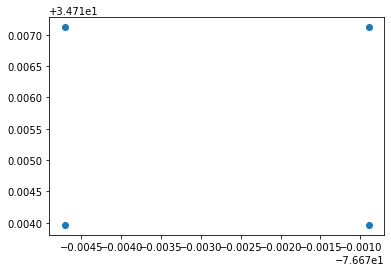

In [501]:
plt.scatter(coords[:,1], coords[:,0])

In [502]:
coords

array([[ 34.71712018, -76.67471145,   0.        ],
       [ 34.71712018, -76.67089055,   0.        ],
       [ 34.71396519, -76.67089062,   0.        ],
       [ 34.71396519, -76.67471138,   0.        ]])

In [503]:
n = np.max(coords[:,0]) # max latitude aka north
s = np.min(coords[:,0]) # min lat aka south
w = np.min(coords[:,1]) # max lon aka west
e = np.max(coords[:,1]) # min lon aka east
n,s,w,e

(34.71712017981583, 34.71396518981994, -76.67471145488702, -76.670890545113)

In [ ]:
! gdal_translate -a_ullr -76.6736197574957 34.71621876649645 -76.67198224250431 34.71486662792644 -of GTiff -a_srs EPSG:4326 my_file.png output_file.tif

In [506]:
! gdal_translate -a_ullr -76.67471145488702 34.71712017981583 -76.670890545113 34.71396518981994 -of GTiff -a_srs EPSG:4326 my_file.png output_file_2.tif

Input file size is 1750, 1750
0...10...20...30...40...50...60...70...80...90...100 - done.


In [439]:
img.altitude

46.298

In [440]:
import rasterio
from rasterio.warp import reproject
from rasterio.enums import Resampling

# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():
    
    # open the original image to get some of the basic metadata
    with rasterio.open(path_name, 'r') as src:
        profile = src.profile
        
        print(profile)
        # create the transform from the GCPs
        #tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        #print(np.array(src.read()))
        
        src_crs = "EPSG:4326"  # This is the crs of the GCPs

        # Destination: a 1024 x 1024 dataset in WGS84
        dst_raster = np.zeros((750, 750), dtype=np.uint16)
        dst_crs = "EPSG:4326"

        #tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        tsfm = rasterio.transform.from_bounds(w, s, e, n, 750, 750)
        #tsfm = rasterio.transform.from_origin(w, n, scaling, scaling)

#         new_raster, dst_transform = reproject(
#             #source=np.array(src.read()),
#             source = top_im,
#             destination=dst_raster,
#             dst_transform=tsfm,
#             gcps=[gcp1,gcp2,gcp3,gcp4],
#             src_crs=src_crs,
#             dst_crs=dst_crs,
#             resampling=Resampling.nearest,
#             #**kwargs
#         )

        profile.update(
            dtype=rasterio.uint16,
            transform = tsfm,
            crs=dst_crs,
            width=dst_raster.shape[0], # TODO unsure if this is correct order
            height=dst_raster.shape[1]
        )

        print(profile)

        with rasterio.open('top_im_IMG_0097_4_mod_2.tif', 'w', **profile) as dst:
            dst.write(top_im.astype(rasterio.uint16), 1)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2064, 'height': 1544, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 750, 'height': 750, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(2.1833533218493056e-06, 0.0, -76.6736197574957,
       0.0, -1.8028514266840527e-06, 34.71621876649645), 'tiled': False, 'interleave': 'band'}


In [441]:
print(profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 750, 'height': 750, 'count': 1, 'crs': 'EPSG:4326', 'transform': Affine(2.1833533218493056e-06, 0.0, -76.6736197574957,
       0.0, -1.8028514266840527e-06, 34.71621876649645), 'tiled': False, 'interleave': 'band'}


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 750, 'height': 750, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(2.1833533218493056e-06, 0.0, -76.6736197574957,
       0.0, -1.8028514266840527e-06, 34.71621876649645)}


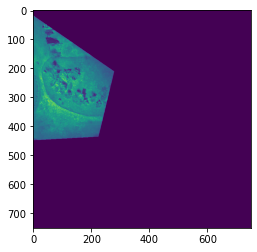

In [442]:
with rasterio.open('top_im_IMG_0097_4_mod_2.tif') as source:
    print(source.read(1))
    plt.imshow(source.read(1))
    print(source.meta)

In [179]:
import xarray as xr
da = xr.open_rasterio('example_uint16_merc.tif', cache=False)
da

<xarray.DataArray (band: 1, y: 1024, x: 1024)>
[1048576 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 34.64 34.64 34.64 34.64 ... 34.64 34.64 34.64 34.64
  * x        (x) float64 -76.55 -76.55 -76.55 -76.55 ... -76.55 -76.55 -76.55
Attributes:
    transform:      (1.5456137586836946e-07, -1.70038986657962e-08, -76.54597...
    crs:            +init=epsg:3857
    res:            (1.558648759971497e-07, 9.2409574961771e-08)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [137]:
da[0].x.min(), da[0].x.max()

(<xarray.DataArray 'x' ()>
 array(-76.54597419)
 Coordinates:
     band     int64 1,
 <xarray.DataArray 'x' ()>
 array(-76.54581607)
 Coordinates:
     band     int64 1)

In [139]:
da[0].y.min(), da[0].y.max()

(<xarray.DataArray 'y' ()>
 array(34.63840682)
 Coordinates:
     band     int64 1,
 <xarray.DataArray 'y' ()>
 array(34.63849974)
 Coordinates:
     band     int64 1)

In [ ]:
ccrs.

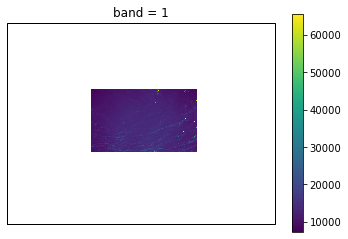

In [180]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr


# Read the data
da = xr.open_rasterio('example_uint16_merc.tif')

crs = ccrs.PlateCarree()

# Plot on a map
ax = plt.subplot(projection=crs)
da[0].plot.imshow(ax=ax, transform=crs)
ax.coastlines('10m', color='black')
ax.set_extent([-76.5457,-76.5461,34.6383,34.6386])
plt.show()

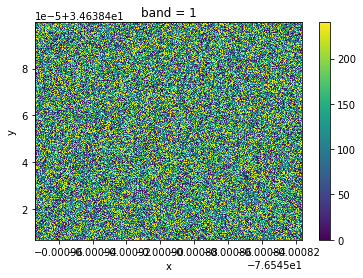

In [133]:
da[0].plot.pcolormesh(x="x", y="y")

AttributeError: 'AxesSubplot' object has no attribute 'coastlines'

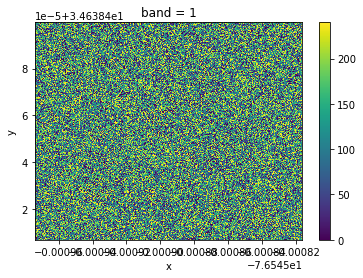

In [80]:
p = ds.plot()
p.axes.coastlines()


(array([195920.,      0.,      0., 201471.,      0.,      0., 198268.,
             0.,      0.,      0., 200633.,      0.,      0., 196600.,
             0.,      0., 200677.,      0.,      0.,      0., 197562.,
             0.,      0., 200759.,      0.,      0., 196142.,      0.,
             0.,      0., 201374.,      0.,      0., 198913.,      0.,
             0., 201610.,      0.,      0.,      0., 196287.,      0.,
             0., 198199.,      0.,      0., 201125.,      0.,      0.,
        201276.]),
 array([  0. ,   4.8,   9.6,  14.4,  19.2,  24. ,  28.8,  33.6,  38.4,
         43.2,  48. ,  52.8,  57.6,  62.4,  67.2,  72. ,  76.8,  81.6,
         86.4,  91.2,  96. , 100.8, 105.6, 110.4, 115.2, 120. , 124.8,
        129.6, 134.4, 139.2, 144. , 148.8, 153.6, 158.4, 163.2, 168. ,
        172.8, 177.6, 182.4, 187.2, 192. , 196.8, 201.6, 206.4, 211.2,
        216. , 220.8, 225.6, 230.4, 235.2, 240. ]),
 <BarContainer object of 50 artists>)

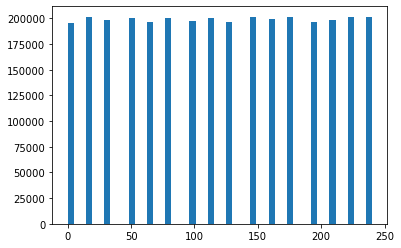

In [308]:
plt.hist(src.read().flatten(),bins=50)

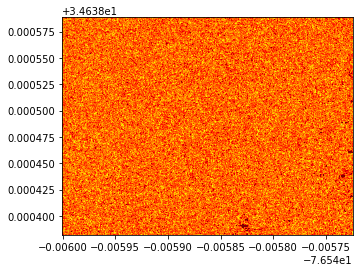

<AxesSubplot:>

In [313]:
from rasterio.plot import show
src = rasterio.open("example3.tif")
show(src,clim=(0,150),cmap='jet')

In [ ]:
gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

In [317]:
import shutil
from osgeo import gdal, osr

orig_fn = 'example.tif'
output_fn = 'output2.tif'

# Create a copy of the original file and save it as the output filename:
shutil.copy(orig_fn, output_fn)
# Open the output file for writing for writing:
ds = gdal.Open(output_fn, gdal.GA_Update)
# Set spatial reference:
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326) #2193 refers to the NZTM2000, but can use any desired projection

# Enter the GCPs
#   Format: [map x-coordinate(longitude)], [map y-coordinate (latitude)], [elevation],
#   [image column index(x)], [image row index (y)]
gcps = [gdal.GCP(coords[0,0], coords[0,1], 0, 0, 0),
        gdal.GCP(coords[1,0], coords[1,1], 0, 0, image_size[0]-1),
        gdal.GCP(coords[2,0], coords[2,1], 0, image_size[1]-1, image_size[0]-1),
        gdal.GCP(coords[3,0], coords[3,1], 0, image_size[1]-1, 0)]

# Apply the GCPs to the open output file:
ds.SetGCPs(gcps, sr.ExportToWkt())

# Close the output file in order to be able to work with it in other programs:
ds = None

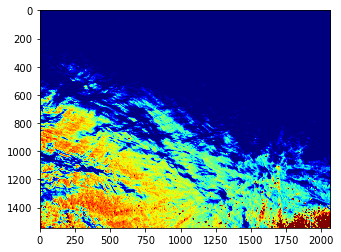

<AxesSubplot:>

In [324]:
from rasterio.plot import show
src = rasterio.open("output2.tif")
show(src,clim=(0,10),cmap='jet')

In [319]:
import rioxarray
ds5 = rioxarray.open_rasterio("output2.tif")
ds5

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rioxarray/_io.py:678: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


<xarray.DataArray (band: 1, y: 1544, x: 2064)>
[3186816 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.542e+03 1.542e+03 1.544e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 2.062e+03 2.062e+03 2.064e+03
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref